In [ ]:
# Path to your trajectory file
traj_path = "/home/alyssenko/c51_project/BOTNet-datasets/dataset_3BPA/test_300K.xyz"
from ase.io import read,write
from ase.visualize import view

frames = read(traj_path, index=":")   # reads all frames
view(frames, viewer="ngl")            # launches the same nglview widget

# write('traj_image.eps', frames[:100])

ValueError: eps-format can only store 1 Atoms object.

In [108]:
import os
import pandas as pd

base_dir = os.path.join(os.getcwd(), 'results_for_analysis')

results = []

for category in sorted(os.listdir(base_dir)):
    category_dir = os.path.join(base_dir, category)
    if not os.path.isdir(category_dir):
        continue

    for run in sorted(os.listdir(category_dir), key=lambda x: int(x) if x.isdigit() else x):
        run_dir = os.path.join(category_dir, run)
        thermo_file = os.path.join(run_dir, 'thermo.csv')
        if not os.path.isfile(thermo_file):
            continue

        try:
            df = pd.read_csv(thermo_file, sep=',', comment='#', encoding='utf-8-sig')
        except Exception as e:
            print(f"Could not read '{thermo_file}': {e}")
            continue

        df.columns = df.columns.str.strip()
        if 'inst_ns_per_day' not in df.columns:
            print(f"Warning: no 'inst_ns_per_day' in {thermo_file}; saw: {df.columns.tolist()}")
            continue

        inst = df['inst_ns_per_day'].dropna()
        if inst.empty:
            print(f"Warning: '{thermo_file}' has no non‑NaN inst_ns_per_day values, skipping.")
            continue

        avg_inst = float(inst.mean())
        results.append((category, run, avg_inst))

df_results = pd.DataFrame(results, columns=['category','run','avg_inst_ns_per_day'])


Could not read '/home/alyssenko/c51_project/results_for_analysis/mace_small/219/thermo.csv': No columns to parse from file


In [109]:
df_results

,category,run,avg_inst_ns_per_day
0,e2gnn_hessian,1,1.505455
1,e2gnn_hessian,2,1.908182
2,e2gnn_hessian,4,1.496364
3,e2gnn_hessian,10,0.834545
4,e2gnn_hessian,21,0.820909
5,e2gnn_hessian,47,0.724545
6,e2gnn_hessian,101,0.666364
7,e2gnn_hessian,219,0.559091
8,e2gnn_hessian,474,0.306364
9,e2gnn_hessian,1024,0.150909


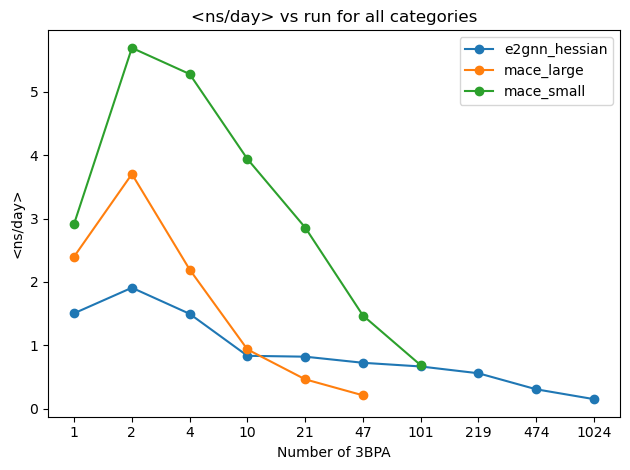

In [110]:
import matplotlib.pyplot as plt

plt.figure()
for category, group in df_results.groupby('category'):
    plt.plot(
        group['run'].to_list(),
        group['avg_inst_ns_per_day'].to_list(),
        marker='o',
        label=category
    )

plt.title("<ns/day> vs run for all categories")
plt.xlabel("Number of 3BPA")

plt.ylabel("<ns/day>")
plt.legend()
plt.tight_layout()
plt.show()


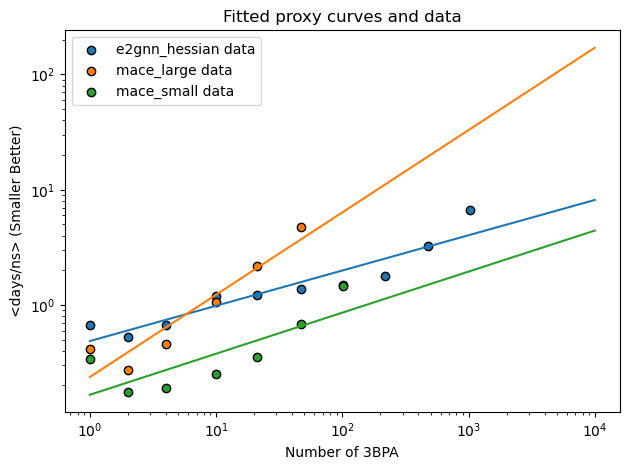

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# ensure 'run' is numeric
df_results['run'] = df_results['run'].astype(int)

# compute the proxy fits (inverse of avg_inst_ns_per_day)
fit_proxy = {}
for category, group in df_results.groupby('category'):
    x = group['run'].values.astype(float)
    y = group['avg_inst_ns_per_day'].values.astype(float)

    # invert to use as speed proxy
    y_inv = 1 / y

    # log-transform
    log_x = np.log(x)
    log_y_inv = np.log(y_inv)

    # linear fit in log-space: log(y_inv) = b*log(x) + log(A)
    b_inv, logA_inv = np.polyfit(log_x, log_y_inv, 1)
    A_inv = np.exp(logA_inv)

    fit_proxy[category] = {'A': A_inv, 'b': b_inv}

# prepare x values for plotting (from min run up to 10000)
x_min = df_results['run'].min()
x_max = 10000
x_plot = np.logspace(np.log10(x_min), np.log10(x_max), 200)

plt.figure()

# plot the fitted curves
for category, params in fit_proxy.items():
    A_inv = params['A']
    b_inv = params['b']
    y_plot = A_inv * x_plot**b_inv
    plt.plot(x_plot, y_plot)

# scatter the original proxy data points
for category, group in df_results.groupby('category'):
    x = group['run'].astype(float)
    y_inv = 1 / group['avg_inst_ns_per_day'].astype(float)
    plt.scatter(x, y_inv, marker='o', edgecolor='k', label=f"{category} data")

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of 3BPA")
plt.ylabel("<days/ns> (Smaller Better)")
plt.title("Fitted proxy curves and data")
plt.legend()
plt.tight_layout()
plt.show()


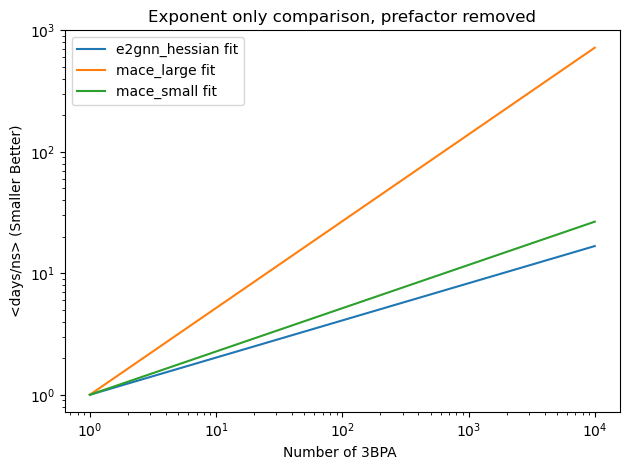

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# ensure 'run' is numeric
df_results['run'] = df_results['run'].astype(int)

# compute the proxy fits (inverse of avg_inst_ns_per_day)
fit_proxy = {}
for category, group in df_results.groupby('category'):
    if category!="lj":
        x = group['run'].values.astype(float)
        y = group['avg_inst_ns_per_day'].values.astype(float)

        # invert to use as speed proxy
        y_inv = 1 / y

        # log-transform
        log_x = np.log(x)
        log_y_inv = np.log(y_inv)

        # linear fit in log-space: log(y_inv) = b*log(x) + log(A)
        b_inv, logA_inv = np.polyfit(log_x, log_y_inv, 1)
        A_inv = np.exp(logA_inv)

        fit_proxy[category] = {'A': A_inv, 'b': b_inv}

# prepare x values for plotting (from min run up to 10000)
x_min = df_results['run'].min()
x_max = 10000
x_plot = np.logspace(np.log10(x_min), np.log10(x_max), 200)

plt.figure()

# plot the fitted curves without prefactor
for category, params in fit_proxy.items():
    b_inv = params['b']
    y_plot = x_plot**b_inv
    plt.plot(x_plot, y_plot, label=f"{category} fit")

# # scatter the normalized data points (remove prefactor)
# for category, group in df_results.groupby('category'):
#     A_inv = fit_proxy[category]['A']
#     x = group['run'].astype(float)
#     y_inv = 1 / group['avg_inst_ns_per_day'].astype(float)
#     y_norm = y_inv / A_inv
#     plt.scatter(x, y_norm, marker='o', edgecolor='k', label=f"{category} data")

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of 3BPA ")
plt.ylabel("<days/ns> (Smaller Better)")
plt.title("Exponent only comparison, prefactor removed")
plt.legend()
plt.tight_layout()
plt.show()


In [127]:
pd.DataFrame.from_dict(fit_proxy, orient='index').reset_index().rename(columns={'index': 'category',"A":"prefactor","b":"exponent"})

,category,prefactor,exponent
0,e2gnn_hessian,0.485963,0.306043
1,mace_large,0.237140,0.714329
2,mace_small,0.166159,0.356233


In [118]:
mace_large = (
    df_results[df_results['category'] == 'mace_large']
    .loc[:, ['run', 'avg_inst_ns_per_day']]
    .rename(columns={'avg_inst_ns_per_day': 'baseline'})
)

df_with_baseline = df_results.merge(mace_large, on='run', how='left')


df_with_baseline['speedup_vs_mace_large'] = (
    df_with_baseline['avg_inst_ns_per_day'] /
    df_with_baseline['baseline']
)


# print(df_with_baseline)


speedup_pivot = df_with_baseline.pivot(
    index='run',
    columns='category',
    values='speedup_vs_mace_large'
)
print(speedup_pivot)

category  e2gnn_hessian  mace_large  mace_small
run                                            
1              0.627221         1.0    1.215906
2              0.515587         1.0    1.537640
4              0.681792         1.0    2.404971
10             0.892609         1.0    4.212009
21             1.770485         1.0    6.162716
47             3.430806         1.0    6.960150
101                 NaN         NaN         NaN
219                 NaN         NaN         NaN
474                 NaN         NaN         NaN
1024                NaN         NaN         NaN


In [119]:
mace_small = (
    df_results[df_results['category'] == 'mace_small']
    [['run', 'avg_inst_ns_per_day']]
    .rename(columns={'avg_inst_ns_per_day': 'baseline_mace_small'})
)


df_cmp = df_results.merge(mace_small, on='run', how='left')


df_cmp['speedup_vs_mace_small'] = (
    df_cmp['avg_inst_ns_per_day'] / df_cmp['baseline_mace_small']
)


df_cmp = df_cmp[df_cmp['category'] != 'mace_large']


speedup_pivot = df_cmp.pivot(
    index='run',
    columns='category',
    values='speedup_vs_mace_small'
)

print(speedup_pivot)

category  e2gnn_hessian  mace_small
run                                
1              0.515846         1.0
2              0.335310         1.0
4              0.283493         1.0
10             0.211920         1.0
21             0.287290         1.0
47             0.492921         1.0
101            0.971319         1.0
219                 NaN         NaN
474                 NaN         NaN
1024                NaN         NaN


In [7]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import imageio
from ase.io import read
from ase.visualize.plot import plot_atoms

# --- User parameters ---
traj_path   = "/home/alyssenko/c51_project/BOTNet-datasets/dataset_3BPA/test_300K.xyz"
out_gif     = "trajectory.gif"
frame_dir   = "gif_frames"
fps         = 10          # frames per second in the final GIF
dpi         = 150         # resolution of each frame

# 1) Read all frames from the trajectory
frames = read(traj_path, index=":10")

# 2) Make a temporary directory for the frame images
if os.path.isdir(frame_dir):
    shutil.rmtree(frame_dir)
os.makedirs(frame_dir)

# 3) Render each frame to a PNG
filenames = []
for i, atoms in enumerate(frames):
    fig, ax = plt.subplots(figsize=(5,5))
    plot_atoms(atoms,
               ax=ax,
               radii=0.5,               # adjust atom size
               rotation=('45x,30y,0z')) # adjust viewpoint
    ax.set_axis_off()
    fname = os.path.join(frame_dir, f"frame_{i:04d}.png")
    fig.savefig(fname, dpi=dpi, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    filenames.append(fname)

# 4) Build the GIF
with imageio.get_writer(out_gif, mode='I', fps=fps) as writer:
    for fname in filenames:
        image = imageio.imread(fname)
        writer.append_data(image)

# 5) (Optional) Clean up frame images
shutil.rmtree(frame_dir)

print(f"Saved animation to {out_gif}")

Saved animation to trajectory.gif


/tmp/ipykernel_1096007/195761703.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(fname)
